In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from fastai.vision import *

In [2]:
import torch.cuda
torch.cuda.device_count()

1

In [8]:
path = Path('/notebooks/hist-project'); print(path)
data_path = path/'data'
labels = pd.read_csv('/notebooks/hist-project/data/train_labels.csv')
work_path = path/'data/models'

/notebooks/hist-project


In [12]:
labels.rename(columns={'id': 'name'})
labels['id']='train/'+labels['id']+'.tif'

In [13]:
labels.iloc[1,0]

'train/c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif'

In [15]:
data = ImageDataBunch.from_df(data_path,
                              labels,
                              test='test',
                              ds_tfms=get_transforms(do_flip=True,
                                                    flip_vert=True,
                                                    max_lighting=0.1,
                                                    max_warp=0.),
                              size=64).normalize(imagenet_stats)

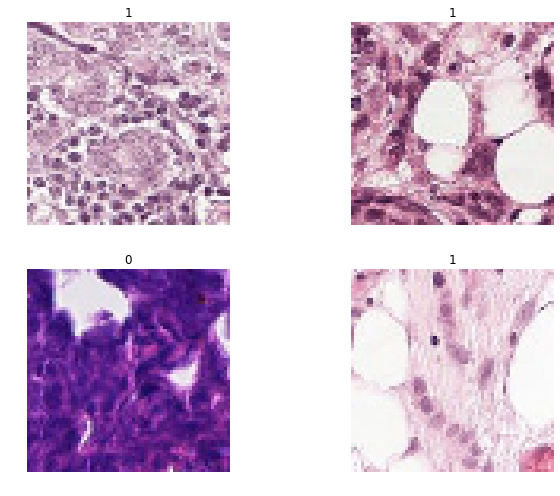

In [16]:
data.show_batch(2, figsize=(10,7))

In [21]:
learn = cnn_learner(data,
                     models.resnet50,
                     metrics=[accuracy, AUROC()],
                     model_dir=work_path)

In [18]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,auroc,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


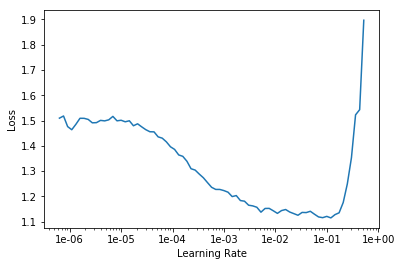

In [19]:
learn.recorder.plot()

In [22]:
learn.fit_one_cycle(4, slice(1e-2))

epoch,train_loss,valid_loss,accuracy,auroc,time
0,0.280420,0.246140,0.907851,0.965964,02:34
1,0.231261,0.540967,0.923895,0.971135,02:33
2,0.197151,0.173032,0.939893,0.982626,02:32
3,0.180059,0.157974,0.941484,0.983957,02:30


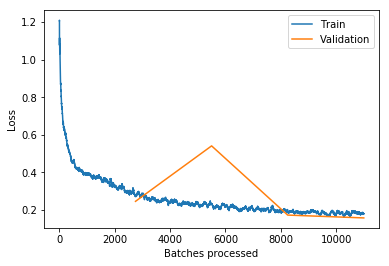

In [24]:
learn.recorder.plot_losses()

In [26]:
learn.save(work_path/'orzel-1')

In [27]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,auroc,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


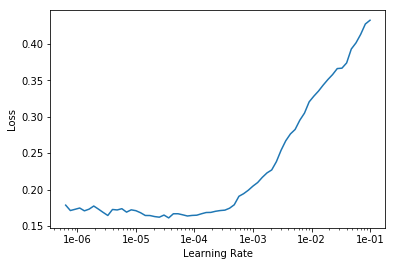

In [28]:
learn.lr_find()
learn.recorder.plot()

In [29]:
learn.fit_one_cycle(5, slice(1e-5, 1e-2/4))

epoch,train_loss,valid_loss,accuracy,auroc,time
0,0.207343,0.172707,0.934985,0.979698,03:20
1,0.176283,0.165898,0.943961,0.983345,03:27
2,0.157921,0.140229,0.947824,0.987028,03:28
3,0.128406,0.833798,0.954210,0.984919,03:27
4,0.117816,0.127301,0.959050,0.990179,03:28


In [30]:
learn.save(work_path/'orzel-2')

epoch,train_loss,valid_loss,accuracy,auroc,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


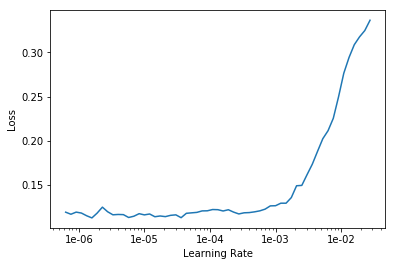

In [31]:
learn.lr_find()
learn.recorder.plot()

In [33]:
#learn.fit_one_cycle(5, slice(1e-6, 1e-2/8))# discarded

epoch,train_loss,valid_loss,accuracy,auroc,time
0,0.124274,0.570136,0.956437,0.986713,03:22
1,0.131318,0.114425,0.960027,0.990732,03:27
2,0.133754,0.112625,0.959164,0.991325,03:28
3,0.121353,0.283800,0.960141,0.987864,03:27
4,0.117775,0.284210,0.959164,0.986055,03:27


In [34]:
learn.load(work_path/'orzel-2')

Learner(data=ImageDataBunch;

Train: LabelList (176020 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
1,0,0,0,0
Path: /notebooks/hist-project/data;

Valid: LabelList (44005 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
1,0,0,0,0
Path: /notebooks/hist-project/data;

Test: LabelList (57458 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: EmptyLabelList
,,,,
Path: /notebooks/hist-project/data, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1)

In [38]:
preds, y = learn.get_preds(ds_type=DatasetType.Test, with_loss=False)

preds_n_avg = np.zeros((len(learn.data.test_ds.items),2))
preds_n_avg = np.sum([preds_n_avg, preds.numpy()], axis=0)

NameError: name 'n_aug' is not defined

In [39]:
preds_n_avg

array([[1.535157e-02, 9.846485e-01],
       [1.037477e-01, 8.962522e-01],
       [1.404694e-03, 9.985953e-01],
       [9.961343e-01, 3.865787e-03],
       ...,
       [9.909273e-01, 9.072687e-03],
       [9.999967e-01, 3.338033e-06],
       [9.800104e-01, 1.998960e-02],
       [9.408983e-01, 5.910164e-02]])

In [40]:
SAMPLE_SUB = data_path/'sample_submission.csv'
sample_df = pd.read_csv(SAMPLE_SUB)
sample_list = list(sample_df.id)

In [41]:
tumor_preds = preds_n_avg[:, 1]

In [42]:
pred_list = [p for p in tumor_preds]

In [44]:
pred_dic = dict((key, value) for (key, value) in zip(learn.data.test_ds.items, pred_list))

In [55]:
pred_list_cor = [pred_dic[Path(str('/notebooks/hist-project/data/test/') + id + '.tif')] for id in sample_list]

In [56]:
df_sub = pd.DataFrame({'id':sample_list,'label':pred_list_cor})

In [59]:
df_sub.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0.005426
1,95596b92e5066c5c52466c90b69ff089b39f2737,0.183618
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0.000199
3,2c35657e312966e9294eac6841726ff3a748febf,0.015834
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0.054755


In [60]:
df_sub.to_csv(path/'submission_preds.csv', header=True, index=False)